# CLASSIFICATION WITH MULTIMODAL INPUT DATA

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
import logging
tf.get_logger().setLevel(logging.ERROR)

In [2]:
EPOCHS = 20
MAX_WORDS = 8
EMBEDDING_WIDTH = 4

# Load training and test datasets.
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Standardize the data.
mean = np.mean(train_images)
stddev = np.std(train_images)
train_images = (train_images - mean) / stddev
test_images = (test_images - mean) / stddev

11501568/11490434 [==============================] - 0s 0us/step


In [3]:
# Function to create second modality.
def create_text(tokenizer, labels):
    text = []
    for i, label in enumerate(labels):
        if i % 2 == 0:
            if label < 5:
                text.append('lower half')
            else:
                text.append('upper half')
        else:
            if label % 2 == 0:
                text.append('even number')
            else:
                text.append('odd number')
    text = tokenizer.texts_to_sequences(text)
    text = pad_sequences(text)
    return text

# Create second modality for training and test set.
vocabulary = ['lower', 'upper', 'half', 'even', 'odd', 'number']
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(vocabulary)
train_text = create_text(tokenizer, train_labels)
test_text = create_text(tokenizer, test_labels)

In [ ]:
# Create model with functional API.
image_input = Input(shape=(28, 28))
text_input = Input(shape=(2, ))

# Declare layers.
embedding_layer = Embedding(output_dim=EMBEDDING_WIDTH,
                            input_dim = MAX_WORDS)
lstm_layer = LSTM(8)
flatten_layer = Flatten()
concat_layer = Concatenate()
dense_layer = Dense(25,activation='relu')
output_layer = Dense(10, activation='softmax')

# Connect layers.
embedding_output = embedding_layer(text_input)
lstm_output = lstm_layer(embedding_output)
flatten_output = flatten_layer(image_input)
concat_output = concat_layer([lstm_output, flatten_output])
dense_output = dense_layer(concat_output)
outputs = output_layer(dense_output)

# Build and train model.
model = Model([image_input, text_input], outputs)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics =['accuracy'])
model.summary()
history = model.fit([train_images, train_text], train_labels,
                    validation_data=([test_images, test_text],
                                     test_labels), epochs=EPOCHS,
                    batch_size=64, verbose=2, shuffle=True)

7
['upper half']


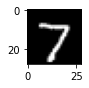

Predictions with correct input:
Digit: 7, probability: 1.00e+00
Digit: 9, probability: 2.76e-08
Digit: 2, probability: 4.89e-10
Digit: 8, probability: 2.71e-11
Digit: 5, probability: 8.72e-12
Digit: 3, probability: 3.60e-12
Digit: 6, probability: 5.55e-13
Digit: 0, probability: 1.46e-14
Digit: 4, probability: 1.68e-16
Digit: 1, probability: 5.59e-18

Predictions with incorrect input:
Digit: 7, probability: 9.67e-01
Digit: 2, probability: 3.21e-02
Digit: 3, probability: 2.79e-04
Digit: 0, probability: 1.51e-04
Digit: 4, probability: 4.60e-06
Digit: 1, probability: 1.01e-08
Digit: 9, probability: 2.65e-09
Digit: 8, probability: 9.85e-11
Digit: 5, probability: 7.87e-11
Digit: 6, probability: 2.45e-12


In [5]:
# Print input modalities and output for one test example.
print(test_labels[0])
print(tokenizer.sequences_to_texts([test_text[0]]))
plt.figure(figsize=(1, 1))
plt.imshow(test_images[0], cmap=plt.get_cmap('gray'))
plt.show()

# Predict test example.
y = model.predict([test_images[0:1], np.array(
    tokenizer.texts_to_sequences(['upper half']))])[0] #7
print('Predictions with correct input:')
for i in range(len(y)):
    index = y.argmax()
    print('Digit: %d,' %index, 'probability: %5.2e' %y[index])
    y[index] = 0

# Predict same test example but with modified textual description.
print('\nPredictions with incorrect input:')
y = model.predict([test_images[0:1], np.array(
    tokenizer.texts_to_sequences(['lower half']))])[0] #7
for i in range(len(y)):
    index = y.argmax()
    print('Digit: %d,' %index, 'probability: %5.2e' %y[index])
    y[index] = 0